# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

# Carga de datos

In [ ]:
# Import and charge the data
df = pd.read_csv("https://raw.githubusercontent.com/narencastellon/Mi-Dataset/main/bank_marketing.csv")
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


# Análisis Exploratorio

## Exploración de valores nulos

In [ ]:
null_counts = df.isnull().sum()
null_percentage = (null_counts / len(df)) * 100

# Crear DataFrame de resumen
null_summary = pd.DataFrame({
    'Tipo': df.dtypes,
    'Valores Nulos': null_counts,
    'Porcentaje (%)': null_percentage
}).sort_values('Valores Nulos', ascending=False)

display(null_summary)

,Tipo,Valores Nulos,Porcentaje (%)
age,int64,0,0.0
job,object,0,0.0
marital,object,0,0.0
education,object,0,0.0
default,object,0,0.0
balance,int64,0,0.0
housing,object,0,0.0
loan,object,0,0.0
contact,object,0,0.0
day,int64,0,0.0


In [ ]:
if null_counts.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Mapa de Valores Nulos')
    plt.show()
else:
    print("No se encontraron valores nulos en el dataset")

No se encontraron valores nulos en el dataset


## Identificación de tipos de variables

In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Remover la variable objetivo si existe
target_candidates = ['deposit']
target_column = None
for col in target_candidates:
    if col in df.columns:
        target_column = col
        if col in categorical_columns:
            categorical_columns.remove(col)
        elif col in numeric_columns:
            numeric_columns.remove(col)
        break

print(f"Variables identificadas:")
print(f" • Variables numéricas ({len(numeric_columns)}): {numeric_columns}")
print(f" • Variables categóricas ({len(categorical_columns)}): {categorical_columns}")

Variables identificadas:
 • Variables numéricas (7): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
 • Variables categóricas (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


## Análisis de variables categóricas

,Variable,Valores Únicos,Valor Más Frecuente,Frecuencia,Porcentaje
0,job,12,management,2566,22.988712
1,marital,3,married,6351,56.898405
2,education,4,secondary,5476,49.059308
3,default,2,no,10994,98.494893
4,housing,2,no,5881,52.687690
5,loan,2,no,9702,86.919907
6,contact,3,cellular,8042,72.048020
7,month,12,may,2824,25.300125
8,poutcome,4,unknown,8326,74.592367


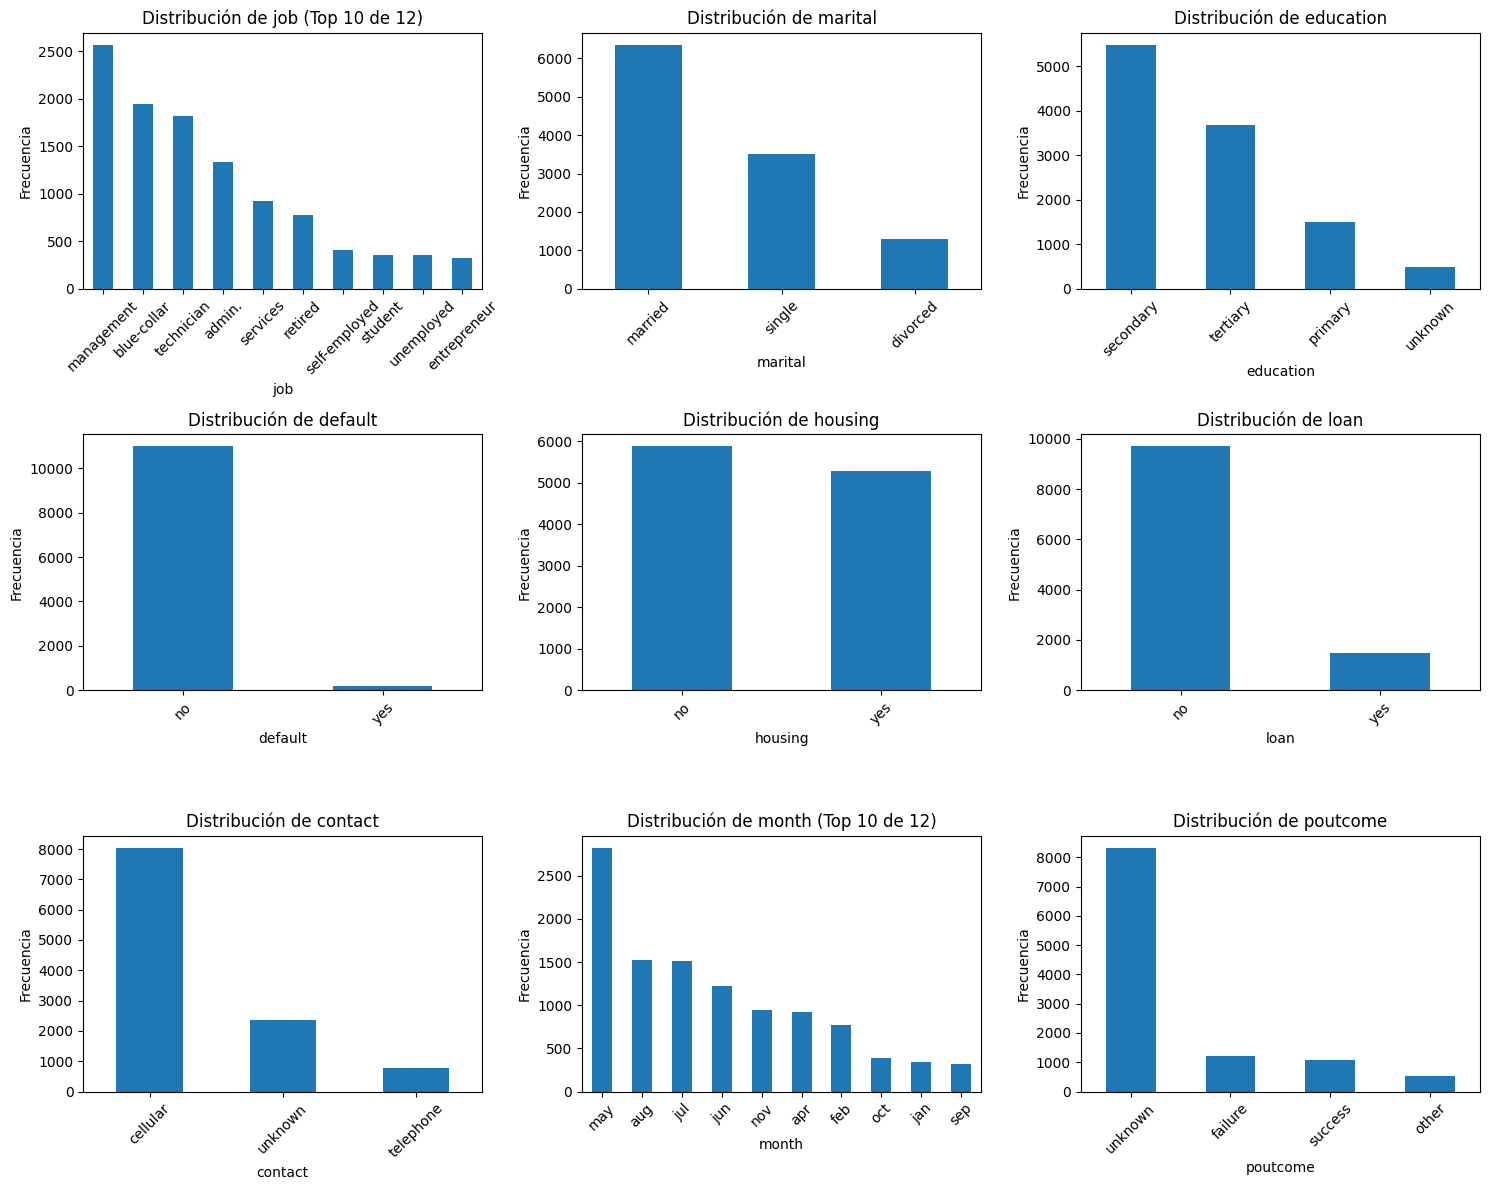

In [ ]:
if categorical_columns:
    # Análisis de cardinalidad
    categorical_info = []
    for col in categorical_columns:
        unique_values = df[col].nunique()
        most_frequent = df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A'
        most_frequent_count = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
        categorical_info.append({
            'Variable': col,
            'Valores Únicos': unique_values,
            'Valor Más Frecuente': most_frequent,
            'Frecuencia': most_frequent_count,
            'Porcentaje': (most_frequent_count/len(df))*100
        })

    categorical_df = pd.DataFrame(categorical_info)
    display(categorical_df)
    print("\n\n")

    # Visualizar distribuciones de variables categóricas
    n_cols = min(3, len(categorical_columns))
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten() if len(categorical_columns) > 1 else [axes]

    for i, col in enumerate(categorical_columns):
        ax = axes[i] if len(categorical_columns) > 1 else axes[0]

        # Solo mostrar top 10 categorías si hay muchas
        value_counts = df[col].value_counts()
        if len(value_counts) > 10:
            value_counts = value_counts.head(10)
            title_suffix = f" (Top 10 de {df[col].nunique()})"
        else:
            title_suffix = ""

        value_counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Distribución de {col}{title_suffix}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)

    # Ocultar subplots vacíos
    for i in range(len(categorical_columns), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

## Análisis de variables numéricas

Estadísticas descriptivas detalladas:


,count,mean,std,min,25%,50%,75%,max,IQR,CV
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0,17.00,0.288935
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0,1586.00,2.110129
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0,14.00,0.537790
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0,358.00,0.933156
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0,2.00,1.085175
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0,21.75,2.118789
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0,1.00,2.752974




 Análisis de outliers (método IQR):


,Variable,Outliers,Porcentaje,Límite Inferior,Límite Superior
0,age,171,1.531984,6.500,74.500
1,balance,1055,9.451711,-2257.000,4087.000
2,day,0,0.000000,-13.000,43.000
3,duration,636,5.697904,-399.000,1033.000
4,campaign,601,5.384340,-2.000,6.000
5,pdays,2750,24.637162,-33.625,53.375
6,previous,1258,11.270382,-1.500,2.500


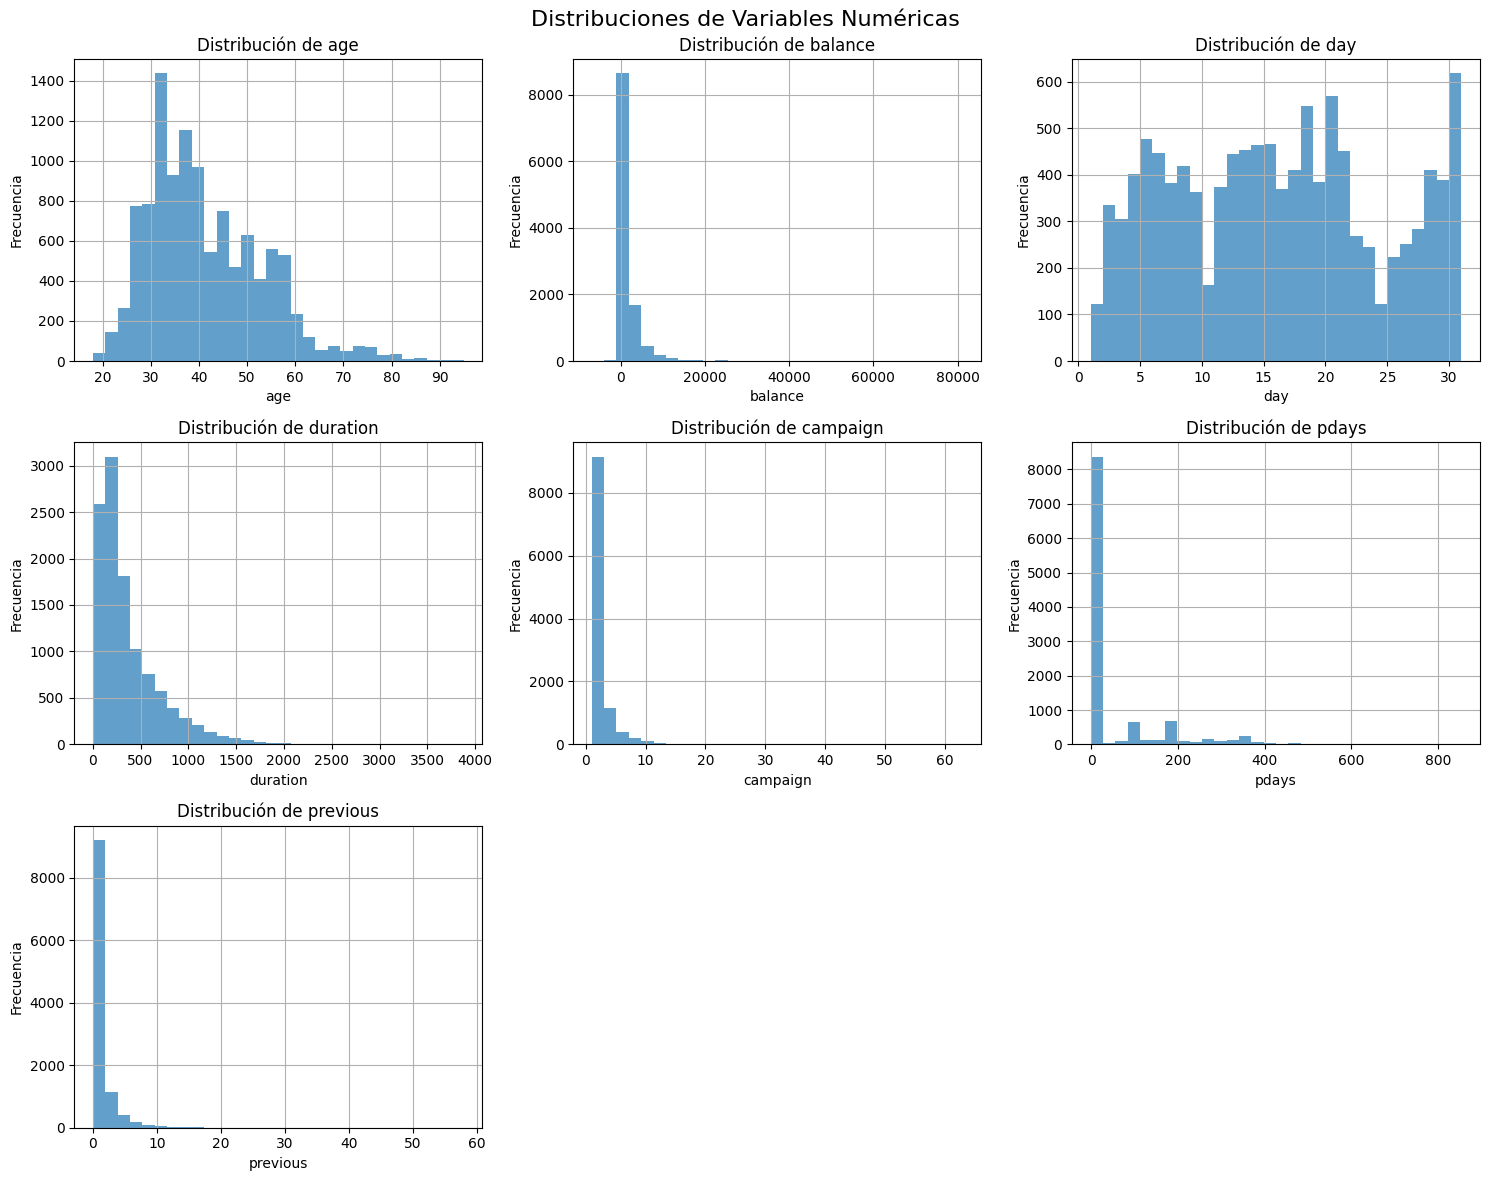

In [ ]:
if numeric_columns:
    # Estadísticas descriptivas detalladas
    numeric_stats = df[numeric_columns].describe().T
    numeric_stats['IQR'] = numeric_stats['75%'] - numeric_stats['25%']
    numeric_stats['CV'] = numeric_stats['std'] / numeric_stats['mean']

    print("Estadísticas descriptivas detalladas:")
    display(numeric_stats)

    # Detección de outliers usando IQR
    print("\n\n Análisis de outliers (método IQR):")
    outliers_info = []
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_info.append({
            'Variable': col,
            'Outliers': len(outliers),
            'Porcentaje': (len(outliers)/len(df))*100,
            'Límite Inferior': lower_bound,
            'Límite Superior': upper_bound
        })

    outliers_df = pd.DataFrame(outliers_info)
    display(outliers_df)
    print("\n")

    # Visualizaciones de variables numéricas
    n_cols = min(3, len(numeric_columns))
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

    # Histogramas
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten() if len(numeric_columns) > 1 else [axes]

    for i, col in enumerate(numeric_columns):
        ax = axes[i] if len(numeric_columns) > 1 else axes[0]
        df[col].hist(bins=30, ax=ax, alpha=0.7)
        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')

    # Ocultar subplots vacíos
    for i in range(len(numeric_columns), len(axes)):
        axes[i].set_visible(False)

    plt.suptitle('Distribuciones de Variables Numéricas', fontsize=16)
    plt.tight_layout()
    plt.show()

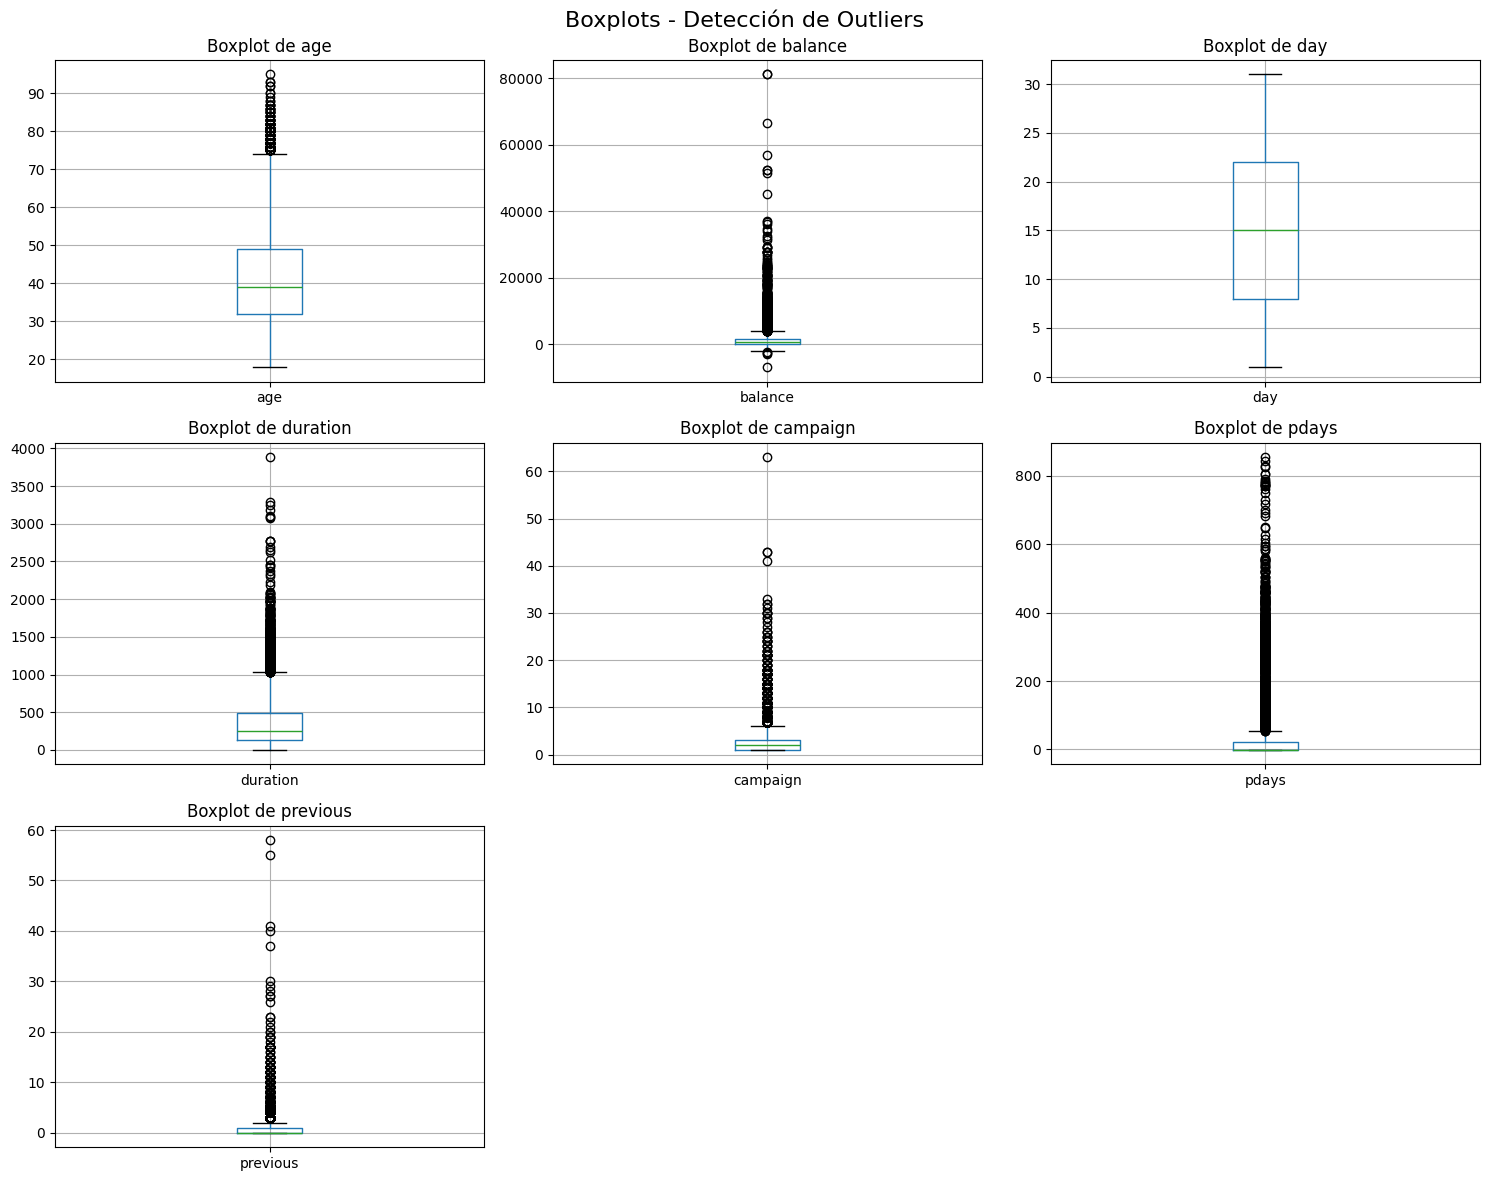

In [ ]:
# Boxplots para detectar outliers visualmente
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten() if len(numeric_columns) > 1 else [axes]

for i, col in enumerate(numeric_columns):
    ax = axes[i] if len(numeric_columns) > 1 else axes[0]
    df.boxplot(column=col, ax=ax)
    ax.set_title(f'Boxplot de {col}')

# Ocultar subplots vacíos
for i in range(len(numeric_columns), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Boxplots - Detección de Outliers', fontsize=16)
plt.tight_layout()
plt.show()


🔗 Matriz de correlación:


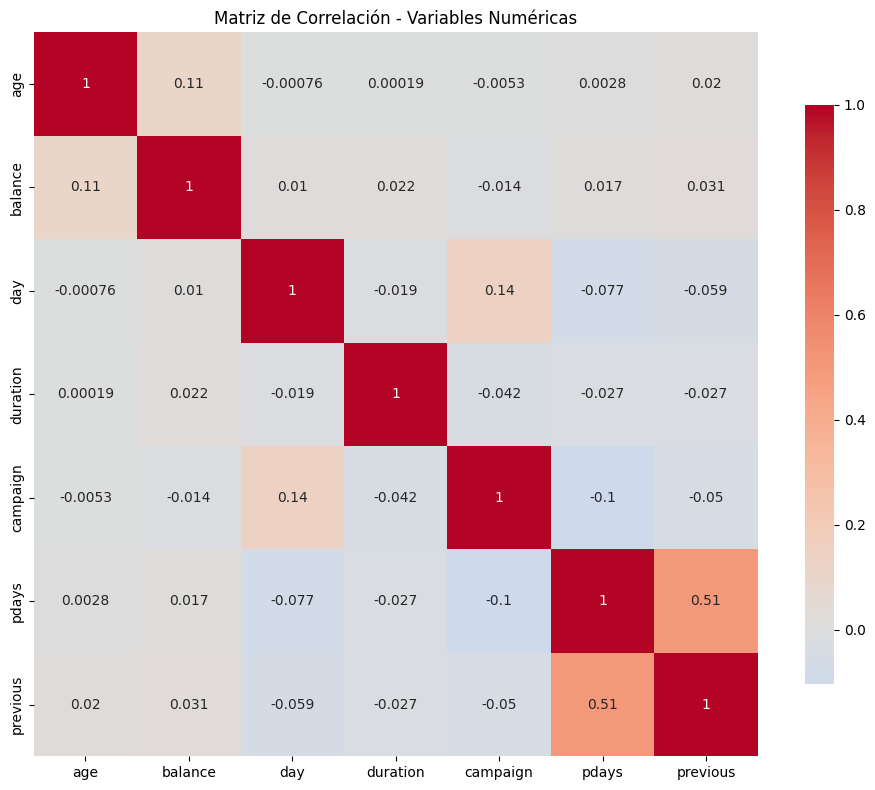

In [ ]:
# Matriz de correlación para variables numéricas
if len(numeric_columns) > 1:
    print("\nMatriz de correlación:")
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numeric_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
                center=0, square=True, cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlación - Variables Numéricas')
    plt.tight_layout()
    plt.show()

# Selección del Número de Clústers

In [ ]:
# Preparar datos para clustering (versión simplificada para determinar k)
# Crear una versión básica de preprocesamiento

# Crear copia para preprocesamiento
df_clustering = df.copy()

# Remover variable objetivo si existe
if target_column:
    df_clustering = df_clustering.drop(columns=[target_column])

# Preprocesamiento básico
# Variables categóricas: Label Encoding para reducir dimensionalidad
le_dict = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_clustering[col] = le.fit_transform(df_clustering[col])
    le_dict[col] = le

# Variables numéricas: StandardScaler
scaler = StandardScaler()
df_clustering[numeric_columns] = scaler.fit_transform(df_clustering[numeric_columns])

# Convertir a numpy array
X_simple = df_clustering.values

print(f"Datos preparados para análisis: {X_simple.shape}")

Datos preparados para análisis: (11162, 16)


## Método del Codo

In [ ]:
# Rango de clusters a evaluar
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_simple)

    # Guardar inercia
    inertias.append(kmeans.inertia_)

    # Calcular silhouette score
    sil_score = silhouette_score(X_simple, cluster_labels)
    silhouette_scores.append(sil_score)

    print(f"   k={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

   k=2: Inercia=250976.98, Silhouette=0.257
   k=3: Inercia=191002.06, Silhouette=0.274
   k=4: Inercia=166696.76, Silhouette=0.256
   k=5: Inercia=150890.27, Silhouette=0.219
   k=6: Inercia=142502.18, Silhouette=0.214
   k=7: Inercia=135699.00, Silhouette=0.204
   k=8: Inercia=130055.33, Silhouette=0.183
   k=9: Inercia=124354.85, Silhouette=0.178
   k=10: Inercia=119070.55, Silhouette=0.181


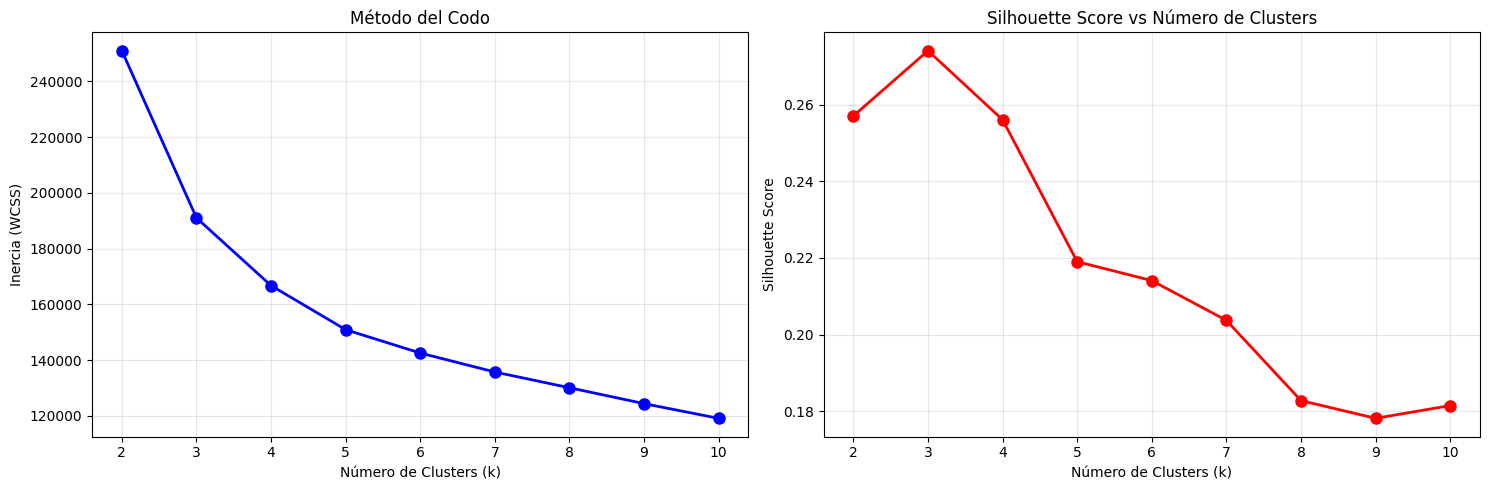

In [ ]:
# Visualizar método del codo y silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Método del codo
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia (WCSS)')
ax1.set_title('Método del Codo')
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Número de Clusters')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Encontrar el k óptimo basado en silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"\nNúmero óptimo de clusters sugerido: {optimal_k}")
print(f"  Silhouette Score: {best_silhouette:.3f}")


Número óptimo de clusters sugerido: 3
Silhouette Score: 0.274


# Creación del Modelo

In [ ]:
# Definir transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

## Modelos a usar

In [ ]:
# Definir modelos a evaluar
models = {
    'KMeans': KMeans(random_state=42, n_init=10),
    'AgglomerativeClustering': AgglomerativeClustering(),
}

# Definir grids de parámetros
param_grids = {
    'KMeans': {
        'clustering__n_clusters': [optimal_k-1, optimal_k, optimal_k+1],
        'clustering__init': ['k-means++', 'random'],
        'clustering__max_iter': [300, 500]
    },
    'AgglomerativeClustering': {
        'clustering__n_clusters': [optimal_k-1, optimal_k, optimal_k+1],
        'clustering__linkage': ['ward', 'complete', 'average']
    }
}

## Entrenamiento y Evaluación

In [ ]:
# Preparar datos
df_model = df.copy()
if target_column:
    X = df_model.drop(columns=[target_column])
else:
    X = df_model

results = []

In [ ]:
for model_name, model in models.items():
    print(f"\nEvaluando {model_name}...")

    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clustering', model)
    ])

    # Evaluar diferentes combinaciones de parámetros
    param_combinations = list(ParameterGrid(param_grids[model_name]))

    for i, params in enumerate(param_combinations):
        try:
            # Configurar parámetros
            pipeline.set_params(**params)

            # Entrenar modelo
            cluster_labels = pipeline.fit_predict(X)

            # Evaluar modelo
            if len(np.unique(cluster_labels)) > 1:
                # Obtener datos transformados para calcular métricas
                X_transformed = pipeline.named_steps['preprocessor'].transform(X)
                sil_score = silhouette_score(X_transformed, cluster_labels)

                # Guardar resultados
                result = {
                    'Modelo': model_name,
                    'Parámetros': params,
                    'N_Clusters': len(np.unique(cluster_labels)),
                    'Silhouette_Score': sil_score,
                    'Pipeline': pipeline
                }
                results.append(result)

                print(f"   Combinación {i+1}/{len(param_combinations)}: Silhouette = {sil_score:.3f}")
            else:
                print(f"   Combinación {i+1}/{len(param_combinations)}: Cluster único - saltando")

        except Exception as e:
            print(f"   Combinación {i+1}/{len(param_combinations)}: Error - {str(e)[:50]}...")


🔄 Evaluando KMeans...
   Combinación 1/12: Silhouette = 0.193
   Combinación 2/12: Silhouette = 0.094
   Combinación 3/12: Silhouette = 0.116
   Combinación 4/12: Silhouette = 0.193
   Combinación 5/12: Silhouette = 0.094
   Combinación 6/12: Silhouette = 0.116
   Combinación 7/12: Silhouette = 0.193
   Combinación 8/12: Silhouette = 0.110
   Combinación 9/12: Silhouette = 0.116
   Combinación 10/12: Silhouette = 0.193
   Combinación 11/12: Silhouette = 0.110
   Combinación 12/12: Silhouette = 0.116

🔄 Evaluando AgglomerativeClustering...
   Combinación 1/9: Silhouette = 0.161
   Combinación 2/9: Silhouette = 0.161
   Combinación 3/9: Silhouette = 0.157
   Combinación 4/9: Silhouette = 0.631
   Combinación 5/9: Silhouette = 0.632
   Combinación 6/9: Silhouette = 0.631
   Combinación 7/9: Silhouette = 0.810
   Combinación 8/9: Silhouette = 0.773
   Combinación 9/9: Silhouette = 0.716


## Selección del Mejor Modelo

In [ ]:
if results:
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame([{
        'Modelo': r['Modelo'],
        'N_Clusters': r['N_Clusters'],
        'Silhouette_Score': r['Silhouette_Score'],
        'Parámetros': str(r['Parámetros'])
    } for r in results])

    # Ordenar por Silhouette Score
    results_df = results_df.sort_values('Silhouette_Score', ascending=False)

    print(f"\nResultados de todos los modelos:")
    print("-"*40)
    display(results_df)

    # Obtener mejor modelo
    best_result = max(results, key=lambda x: x['Silhouette_Score'])
    best_model = best_result['Pipeline']
    best_score = best_result['Silhouette_Score']

    print(f"\nMEJOR MODELO ENCONTRADO:")
    print("="*35)
    print(f"   • Modelo: {best_result['Modelo']}")
    print(f"   • Parámetros: {best_result['Parámetros']}")
    print(f"   • Número de Clusters: {best_result['N_Clusters']}")
    print(f"   • Silhouette Score: {best_score:.3f}")

else:
    print("No se pudieron entrenar modelos exitosamente")
    best_model = None


Resultados de todos los modelos:
----------------------------------------


,Modelo,N_Clusters,Silhouette_Score,Parámetros
39,AgglomerativeClustering,2,0.809576,"{'clustering__linkage': 'average', 'clustering..."
18,AgglomerativeClustering,2,0.809576,"{'clustering__linkage': 'average', 'clustering..."
19,AgglomerativeClustering,3,0.773059,"{'clustering__linkage': 'average', 'clustering..."
40,AgglomerativeClustering,3,0.773059,"{'clustering__linkage': 'average', 'clustering..."
41,AgglomerativeClustering,4,0.715592,"{'clustering__linkage': 'average', 'clustering..."
20,AgglomerativeClustering,4,0.715592,"{'clustering__linkage': 'average', 'clustering..."
16,AgglomerativeClustering,3,0.631554,"{'clustering__linkage': 'complete', 'clusterin..."
37,AgglomerativeClustering,3,0.631554,"{'clustering__linkage': 'complete', 'clusterin..."
36,AgglomerativeClustering,2,0.630888,"{'clustering__linkage': 'complete', 'clusterin..."
15,AgglomerativeClustering,2,0.630888,"{'clustering__linkage': 'complete', 'clusterin..."



MEJOR MODELO ENCONTRADO:
   • Modelo: AgglomerativeClustering
   • Parámetros: {'clustering__linkage': 'average', 'clustering__n_clusters': 2}
   • Número de Clusters: 2
   • Silhouette Score: 0.810


# Evaluación del Mejor Modelo

In [ ]:
# AgglomerativeClustering does not have a predict method, use fit_predict on the pipeline
cluster_labels = best_model.fit_predict(X)
X_transformed = best_model.named_steps['preprocessor'].transform(X)

# Calcular métricas detalladas
silhouette_avg = silhouette_score(X_transformed, cluster_labels)
sample_silhouette_values = silhouette_samples(X_transformed, cluster_labels)

print(f"Métricas del modelo:")
print(f"   • Silhouette Score promedio: {silhouette_avg:.3f}")
print(f"   • Número de clusters: {len(np.unique(cluster_labels))}")
print(f"   • Distribución de clusters:")

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"     - Cluster {cluster}: {count} observaciones ({percentage:.1f}%)")

Métricas del modelo:
   • Silhouette Score promedio: 0.716
   • Número de clusters: 4
   • Distribución de clusters:
     - Cluster 0: 14 observaciones (0.1%)
     - Cluster 1: 11139 observaciones (99.8%)
     - Cluster 2: 8 observaciones (0.1%)
     - Cluster 3: 1 observaciones (0.0%)


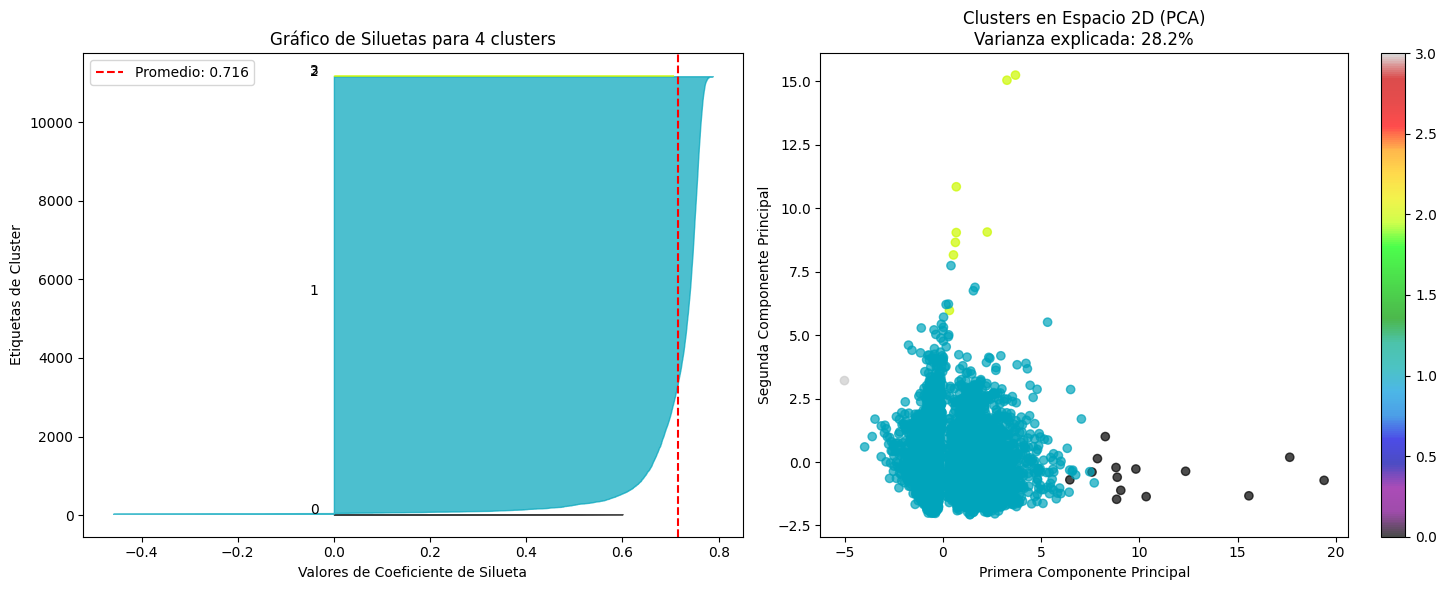

In [ ]:
# Configurar la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de siluetas
y_lower = 10
n_clusters = len(np.unique(cluster_labels))
colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_clusters))

for i, color in zip(range(n_clusters), colors):
    # Obtener valores de silueta para el cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiquetar clusters
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_xlabel('Valores de Coeficiente de Silueta')
ax1.set_ylabel('Etiquetas de Cluster')
ax1.set_title(f'Gráfico de Siluetas para {n_clusters} clusters')

# Línea vertical para el score promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--",
            label=f'Promedio: {silhouette_avg:.3f}')
ax1.legend()

# Gráfico de distribución de clusters en 2D (usando PCA)
if X_transformed.shape[1] > 2:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_transformed)
    explained_variance = pca.explained_variance_ratio_.sum()
else:
    X_pca = X_transformed
    explained_variance = 1.0

scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                      cmap='nipy_spectral', alpha=0.7)

# Marcar centroides si es K-Means
if hasattr(best_model.named_steps['clustering'], 'cluster_centers_'):
    centers = best_model.named_steps['clustering'].cluster_centers_
    if centers.shape[1] > 2:
        centers_pca = pca.transform(centers)
    else:
        centers_pca = centers

    ax2.scatter(centers_pca[:, 0], centers_pca[:, 1],
                c='red', marker='x', s=200, linewidths=3, label='Centroides')
    ax2.legend()

ax2.set_xlabel(f'Primera Componente Principal')
ax2.set_ylabel(f'Segunda Componente Principal')
ax2.set_title(f'Clusters en Espacio 2D (PCA)\nVarianza explicada: {explained_variance:.1%}')

plt.colorbar(scatter, ax=ax2)
plt.tight_layout()
plt.show()


Estadísticas de variables numéricas por cluster:


age            balance                day        duration  \
           mean     std       mean        std    mean    std     mean   
Cluster                                                                 
0        35.000   9.106   2305.500   2449.676   9.214  6.104  450.929   
1        41.226  11.901   1484.197   2784.114  15.668  8.421  371.820   
2        60.000  16.750  60969.125  13870.977  12.125  8.061  506.625   
3        45.000     NaN   9051.000        NaN  19.000    NaN  124.000   

                 campaign           pdays          previous          
             std     mean    std     mean      std     mean     std  
Cluster                                                              
0        540.444    3.214  1.762  322.643  221.767   33.214  11.610  
1        346.749    2.503  2.663   50.978  108.135    0.792   1.946  
2        479.555    1.500  0.926   73.875  118.846    0.750   1.165  
3            NaN   63.000    NaN   -1.000      NaN    0.000     NaN

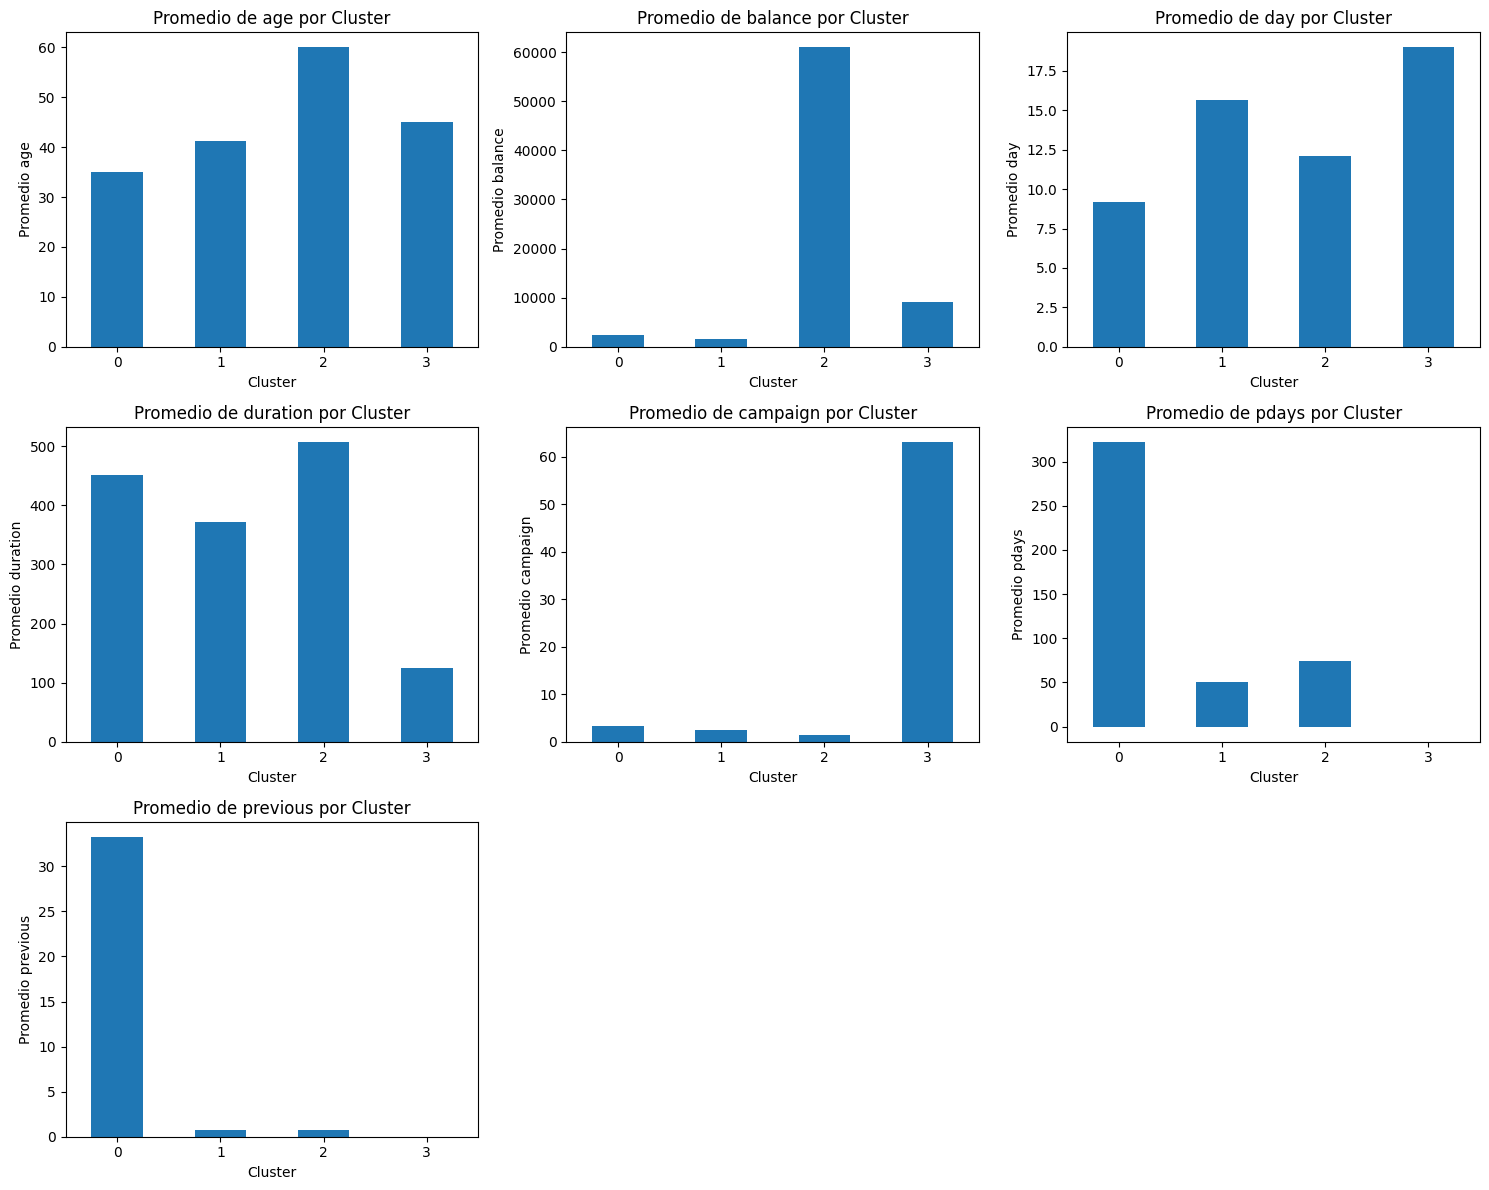

In [ ]:
# Agregar labels al dataframe original
df_analysis = df.copy()
df_analysis['Cluster'] = cluster_labels

# Análisis de variables numéricas por cluster
if numeric_columns:
    print("\nEstadísticas de variables numéricas por cluster:")
    cluster_numeric_stats = df_analysis.groupby('Cluster')[numeric_columns].agg(['mean', 'std']).round(3)
    display(cluster_numeric_stats)
    print("\n")

    # Visualizar promedios por cluster
    cluster_means = df_analysis.groupby('Cluster')[numeric_columns].mean()

    n_cols = 3
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten() if len(numeric_columns) > 1 else [axes]

    for i, col in enumerate(numeric_columns):
        ax = axes[i] if len(numeric_columns) > 1 else axes[0]
        cluster_means[col].plot(kind='bar', ax=ax)
        ax.set_title(f'Promedio de {col} por Cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel(f'Promedio {col}')
        ax.tick_params(axis='x', rotation=0)

    # Ocultar subplots vacíos
    for i in range(len(numeric_columns), len(axes)):
        axes[i].set_visible(False)


    plt.tight_layout()
    plt.show()


Distribución de variables categóricas por cluster:

--- Variable: job ---


job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
Cluster,,,,,,,,,,,,
0,0.071,0.286,0.071,0.000,0.214,0.00,0.000,0.071,0.071,0.214,0.000,0.000
1,0.120,0.174,0.029,0.025,0.230,0.07,0.036,0.083,0.032,0.163,0.032,0.006
2,0.125,0.125,0.125,0.000,0.000,0.25,0.250,0.000,0.000,0.125,0.000,0.000
3,0.000,0.000,0.000,0.000,1.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000


<Figure size 1000x600 with 0 Axes>

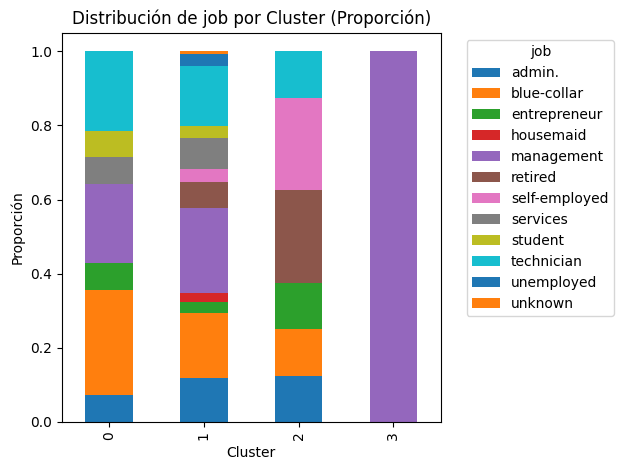


--- Variable: marital ---


marital,divorced,married,single
Cluster,,,
0,0.071,0.429,0.500
1,0.116,0.569,0.315
2,0.250,0.500,0.250
3,0.000,1.000,0.000


<Figure size 1000x600 with 0 Axes>

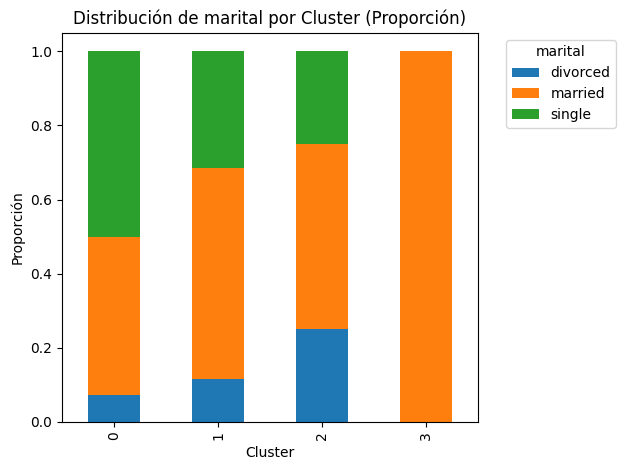


--- Variable: education ---


education,primary,secondary,tertiary,unknown
Cluster,,,,
0,0.143,0.500,0.357,0.000
1,0.134,0.491,0.330,0.044
2,0.125,0.375,0.375,0.125
3,0.000,0.000,0.000,1.000


<Figure size 1000x600 with 0 Axes>

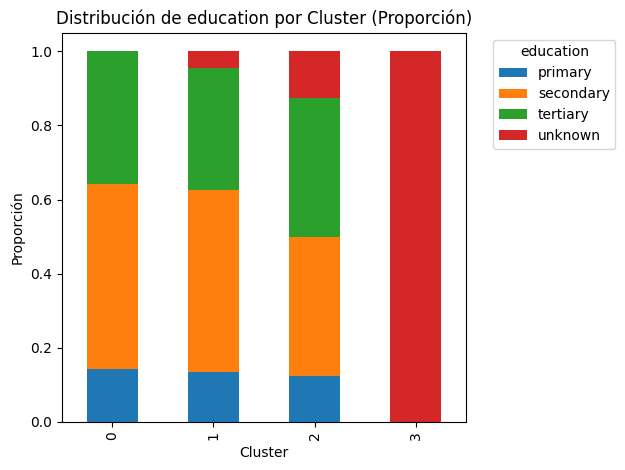

In [ ]:
# Análisis de variables categóricas por cluster
if categorical_columns:
    print(f"\nDistribución de variables categóricas por cluster:")

    for col in categorical_columns[:3]:  # Mostrar solo las primeras 3 para evitar sobrecarga
        print(f"\n--- Variable: {col} ---")
        cluster_cat_dist = pd.crosstab(df_analysis['Cluster'], df_analysis[col], normalize='index')
        display(cluster_cat_dist.round(3))

        # Visualizar
        plt.figure(figsize=(10, 6))
        cluster_cat_dist.plot(kind='bar', stacked=True)
        plt.title(f'Distribución de {col} por Cluster (Proporción)')
        plt.xlabel('Cluster')
        plt.ylabel('Proporción')
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

In [ ]:
print(f"\nRESUMEN FINAL")
print("="*20)
print(f"   • Mejor modelo: {best_result['Modelo']}")
print(f"   • Número óptimo de clusters: {best_result['N_Clusters']}")
print(f"   • Silhouette Score: {best_score:.3f}")
print(f"   • Interpretación del Silhouette Score:")
print()
if best_score >= 0.7:
    print("Excelente estructura de clusters")
elif best_score >= 0.5:
    print("Estructura de clusters razonable")
elif best_score >= 0.25:
    print("Estructura de clusters débil")
else:
    print("Sin estructura clara de clusters")


RESUMEN FINAL
   • Mejor modelo: AgglomerativeClustering
   • Número óptimo de clusters: 2
   • Silhouette Score: 0.810
   • Interpretación del Silhouette Score:

Excelente estructura de clusters


# Save model

In [ ]:
import joblib

# Save the trained model in Colab
joblib.dump(best_model, "best_model.pkl")

print("Model saved successfully!")

Model saved successfully!
